In [1]:
%matplotlib inline

import os
from glob import glob

import datetime as dt

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model

from ipywidgets import interact

from IPython.core.pylabtools import figsize

In [2]:
figsize(15, 9)
figsize(15, 9)

sns.set()

pd.set_option('display.max_columns', 50)

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
data_dir = 'data'

In [4]:
country_map = {
    'US': 'United_States',
    'United States of America': 'United_States',
    'Czechia': 'Czech_Republic',
    'UK': 'United_Kingdom',
    'United Kingdom of Great Britain and Northern Ireland': 'United_Kingdom',
    'Hong Kong SAR': 'Hong_Kong',
    'Russian Federation': 'Russia',
    'Mainland China': 'China',
    'Korea, South': 'South_Korea',
    'Republic of Korea': 'South_Korea',
}

## New York State Hospital Data

https://health.data.ny.gov/Health/Health-Facility-Certification-Information/2g9y-7kqm

In [5]:
ny_hosp_df = pd.read_csv(os.path.join(data_dir, 'ny_health_facilities.csv'))

icu_df = ny_hosp_df[
    (ny_hosp_df['Attribute Type'] == 'Bed') &
    (ny_hosp_df['Attribute Value'] == 'Intensive Care')
]

ICU_BEDS = icu_df['Measure Value'].sum()


len(icu_df)

158

## Severity

https://www.worldometers.info/coronavirus/coronavirus-symptoms/#mild

In [6]:
P_CRITICAL = 0.0188

## ICU Utilization

https://en.wikipedia.org/wiki/List_of_countries_by_hospital_beds

In [7]:
BED_UTILIZATION = 64.0

## COVID-19 Data

https://github.com/CSSEGISandData/COVID-19

In [8]:
covid_time_series_confirmed_path = \
    './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

covid_time_series_recovered_path = \
    './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

covid_time_series_death_path = \
    './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'


confirmed_df = pd.read_csv(covid_time_series_confirmed_path).drop(['Lat', 'Long'], axis=1)
confirmed_df = \
    confirmed_df\
        .rename(columns={'Province/State': 'State', 'Country/Region': 'Country'})\
        .melt(['State', 'Country'], var_name='Date', value_name='Confirmed')\
        .copy()

recovered_df = pd.read_csv(covid_time_series_recovered_path).drop(['Lat', 'Long'], axis=1)
recovered_df = \
    recovered_df\
        .rename(columns={'Province/State': 'State', 'Country/Region': 'Country'})\
        .melt(['State', 'Country'], var_name='Date', value_name='Recovered')\
        .copy()

deaths_df = pd.read_csv(covid_time_series_death_path).drop(['Lat', 'Long'], axis=1)
deaths_df = \
    deaths_df\
        .rename(columns={'Province/State': 'State', 'Country/Region': 'Country'})\
        .melt(['State', 'Country'], var_name='Date', value_name='Deaths')\
        .copy()

MERGE_COLS = ['State', 'Country', 'Date']
covid_df = \
    confirmed_df\
        .merge(recovered_df, on=MERGE_COLS)\
        .merge(deaths_df, on=MERGE_COLS)

covid_df = covid_df[covid_df[['Confirmed', 'Recovered', 'Deaths']].notnull().values.all(axis=1)]

covid_df['Active'] = covid_df['Confirmed'] - covid_df['Deaths'] - covid_df['Recovered']
covid_df['Critical'] = (covid_df['Active'] * P_CRITICAL).astype('int64')

covid_df['Country'] = \
    covid_df['Country'].map(lambda x: country_map.get(x, x.strip().replace(' ', '_')))

covid_df['Date'] = pd.to_datetime(covid_df['Date']).dt.date

covid_df = covid_df.groupby(['Country', 'State', 'Date']).sum().reset_index().copy()
covid_df['Date'] = pd.to_datetime(covid_df['Date'])

covid_df = \
    covid_df[
        (covid_df['Country'] == 'United_States') &
        (
            (covid_df['State'] == 'New York') |
            (covid_df['State'].str.endswith('NY'))
        )
    ].groupby(['Date'])[['Critical']].sum().reset_index()

covid_df = covid_df[covid_df['Critical'] > 0].copy()

covid_df

,Date,Critical
45,2020-03-07,1
46,2020-03-08,1
47,2020-03-09,1
48,2020-03-10,3
49,2020-03-11,4
50,2020-03-12,6
51,2020-03-13,7
52,2020-03-14,9
53,2020-03-15,13
54,2020-03-16,17


## Forecasting

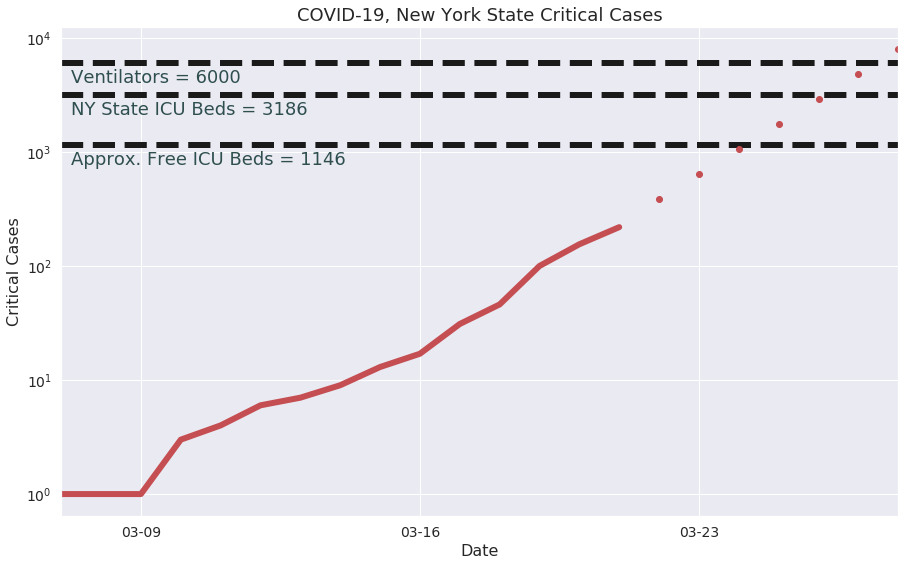

In [9]:
LINEWIDTH=6
log=True

ventilators = 6000
free_beds = int(ICU_BEDS * (1 - BED_UTILIZATION / 100.0))

country_data_df = covid_df.copy()

_, row = next(country_data_df.head(1).iterrows())
first_date = row['Date']

N_DAYS = 7
last_week = country_data_df.tail(N_DAYS)
_, row = next(last_week.head(1).iterrows())

first_date_last_week = row['Date']
last_week_indices = list(range(N_DAYS))

model = linear_model.LinearRegression()
model.fit([[i] for i in last_week_indices], np.log(last_week['Critical']))

N_DAYS_PREDICT = int((np.log(ICU_BEDS) - model.intercept_)/model.coef_) + 3

next_week_indices = list(range(N_DAYS, N_DAYS_PREDICT))
next_week = np.exp(model.predict([[i] for i in next_week_indices]))

predict_df = pd.DataFrame()
predict_df['Date'] = pd.to_datetime([
    first_date_last_week + dt.timedelta(days=i) for i in next_week_indices
])
predict_df['Forecast'] = next_week

concat_df = \
    country_data_df\
        .merge(predict_df, on=['Date'], how='outer')\
        .assign(available_icu=ICU_BEDS)\
        .assign(free_icu=free_beds)\
        .assign(ventilators=ventilators)\
        .reset_index(drop=True)

concat_df['Date'] = concat_df['Date'].dt.date
concat_df.set_index('Date', inplace=True)

ax = concat_df['Critical'].plot(logy=log, lw=LINEWIDTH, style='r-', use_index=True)

positions = [p for p in concat_df.index if p.weekday() == 0]
labels = [l.strftime('%m-%d') for l in positions]

concat_df['available_icu'].plot(logy=log, lw=LINEWIDTH, style='k--', xticks=[], use_index=True)
concat_df['free_icu'].plot(logy=log, lw=LINEWIDTH, style='k--', xticks=[], use_index=True)
concat_df['ventilators'].plot(logy=log, lw=LINEWIDTH, style='k--', xticks=[], use_index=True)

concat_df['Forecast'].plot(logy=log, lw=LINEWIDTH, use_index=True, style='ro')

ax.set_xticks(positions)
ax.set_xticklabels(labels)

ax.annotate(
    'NY State ICU Beds = {}'.format(int(ICU_BEDS)),
    (first_date, ICU_BEDS),
    fontsize=18,
    color='darkslategray',
    xytext=(10, -20),
    textcoords='offset points'
)


ax.annotate(
    'Approx. Free ICU Beds = {}'.format(free_beds),
    (first_date, free_beds),
    fontsize=18,
    color='darkslategray',
    xytext=(10, -20),
    textcoords='offset points'
)


ax.annotate(
    'Ventilators = {}'.format(ventilators),
    (first_date, ventilators),
    fontsize=18,
    color='darkslategray',
    xytext=(10, -20),
    textcoords='offset points'
)

plt.title(
#     'Approximately {} days til hospitals exceed capacity'.format(N_DAYS_PREDICT - N_DAYS),
    'COVID-19, New York State Critical Cases',
    fontsize=BIGGER_SIZE,
)

plt.ylabel('Critical Cases')
plt.show()